# Imporant pixels

You are given a pipeline that trains a fully convolutional autoencoder on the MNIST dataset. The model should train in under 2 minutes and give decent results (mean reconstruction loss <35).

Your task is to write a function that for a given input image and output pixel coordinates produces a list of input pixels that have non-zero contribution to the value of the output pixel. You should measure each pixel's contribution by setting it to the minimal and maximal value over the whole image.


Training pipeline (DO NOT CHANGE THIS SECTION)

In [102]:
import typing
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [103]:
epochs = 5
batch_size = 250
learning_rate = 1e-2
log_interval = 40

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Binarize:
    def __call__(self, sample):
        return torch.bernoulli(sample)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST('./data', train=True, transform=img_transform, download=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = MNIST('./data', train=False, transform=img_transform, download=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [105]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(
            1,
            16,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            bias=False,
        ),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(
            16,
            32,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(
            32,
            64,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                32,
                7, 
                2, 
                0, 
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                16,
                3, 
                1, 
                0, 
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                16,
                8,
                5, 
                1, 
                0, 
                bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                8,
                1,
                4, 
                1, 
                0, 
                bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [106]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / data.size(0)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, data, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))



In [107]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1198.498000
Train Epoch: 1 [10000/60000 (17%)]	Loss: 197.168625
Train Epoch: 1 [20000/60000 (33%)]	Loss: 149.806500
Train Epoch: 1 [30000/60000 (50%)]	Loss: 128.390172
Train Epoch: 1 [40000/60000 (67%)]	Loss: 101.429336
Train Epoch: 1 [50000/60000 (83%)]	Loss: 100.744469

Test set: Average loss: 84.7261

Train Epoch: 2 [0/60000 (0%)]	Loss: 84.302820
Train Epoch: 2 [10000/60000 (17%)]	Loss: 77.431383
Train Epoch: 2 [20000/60000 (33%)]	Loss: 79.398766
Train Epoch: 2 [30000/60000 (50%)]	Loss: 73.409070
Train Epoch: 2 [40000/60000 (67%)]	Loss: 64.332305
Train Epoch: 2 [50000/60000 (83%)]	Loss: 70.229250

Test set: Average loss: 62.6196

Train Epoch: 3 [0/60000 (0%)]	Loss: 61.528266
Train Epoch: 3 [10000/60000 (17%)]	Loss: 56.603125
Train Epoch: 3 [20000/60000 (33%)]	Loss: 55.655973
Train Epoch: 3 [30000/60000 (50%)]	Loss: 55.252437
Train Epoch: 3 [40000/60000 (67%)]	Loss: 59.231168
Train Epoch: 3 [50000/60000 (83%)]	Loss: 49.030203

Test set: Average los

# Important pixels

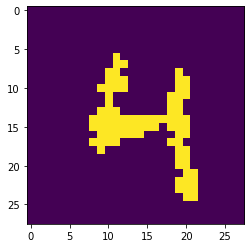

In [108]:
input_batch = next(iter(train_loader))[0][0,:].unsqueeze(0)
input_batch = input_batch.to(device)
plt.imshow(input_batch[0, :].cpu().detach().squeeze().numpy())

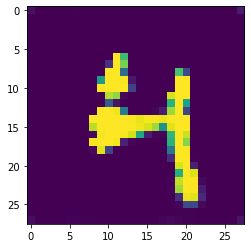

In [109]:
plt.imshow(model(input_batch)[0, :].cpu().detach().squeeze().numpy())

In [110]:
def important_pixels(input_batch: torch.Tensor, model: torchvision.models.segmentation.fcn.FCN, device: torch.device, coordinates: typing.Tuple[int, int]) -> typing.Set[typing.Tuple[int,int]]: 
    model = model.to(device)
    input_batch = input_batch.to(device)

    ################################

    coord_y, coord_x = coordinates
    important = []
    for y in range(28):
        for x in range(28):
            clone = input_batch.clone()
 
            clone[:, :, y, x] = -1
            out1 = model(clone)[0, 0, coord_y, coord_x]
            clone[:, :, y, x] = 1
            out2 = model(clone)[0, 0, coord_y, coord_x]

            if out1 != out2:
                important.append((y, x))

    return set(important)

    ################################



In [111]:
checked_pixel = (0, 0)
pixels = important_pixels(input_batch, model, device, checked_pixel)

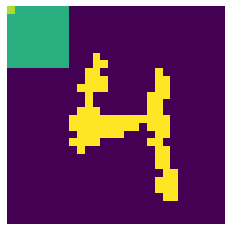

In [112]:
input_image_numpy = input_batch[0, :].cpu().detach().squeeze().numpy()

for pixel in pixels:
    input_image_numpy[pixel[0], pixel[1]] = 0.25

input_image_numpy[checked_pixel[0], checked_pixel[1]] = 0.75

plt.imshow(input_image_numpy)
plt.axis("off")
plt.show()